## Estimate mass

Use overdensity to estimate descendant cluster mass.

In [1]:
import pandas as pd
import numpy as np
import pickle as pcl

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from palettable.tableau import GreenOrange_12
cmap = GreenOrange_12.hex_colors

from scipy.optimize import curve_fit

from methods import factor_h
from methods import z_distort
from methods import get_protoclusters
from overdensity_cylinder import overdensity_cylinder

h = 0.673
L = 480.279 / h

directory = '/lustre/scratch/astro/cl478/protoclusters_data/'
out_directory = 'output/'

Load data

In [2]:
redshifts = ['2p07','3p10','3p95','5p03','5p92','6p97']#,'8p22','8p93','9p72']
zees = [float(z.replace('p','.')) for z in redshifts]

gals_sfr = [None] * len(redshifts)
gals_mstar = [None] * len(redshifts)

for i, z in enumerate(redshifts):
    print i, z
    
    gals_sfr[i] = pd.read_csv('%shenriques2015a_z%s_sfr_r200.csv'%(directory,z), 
                              skiprows=122, skipfooter=1, engine='python')
    
    gals_mstar[i] = pd.read_csv('%shenriques2015a_z%s_stellarMass_r200.csv'%(directory,z), 
                                skiprows=122, skipfooter=1, engine='python')

0 2p07
1 3p10
2 3p95
3 5p03
4 5p92
5 6p97


In [3]:
for i, z in enumerate(zees):
    for gals in [gals_sfr, gals_mstar]:
        gals[i] = z_distort(factor_h(gals[i], h), z, L)

#         print "Filling in NaN values..."
        gals[i].ix[np.isnan(gals[i]['z0_haloId']), 'z0_haloId'] = -1
        gals[i].ix[np.isnan(gals[i]['z0_centralId']), 'z0_centralId'] = -1
        gals[i].ix[np.isnan(gals[i]['z0_central_mcrit200']), 'z0_central_mcrit200'] = 0
    

### $R \;/\; \delta_{z}$  stats

In [76]:
# cylinder_mstar = {z: {'cstats': None, 'clusters': None} for z in zees}
# cylinder_sfr =  {z: {'cstats': None, 'clusters': None} for z in zees}
# cylinder_sfr5 =  {z: {'cstats': None, 'clusters': None} for z in zees}

# for i, z in enumerate(zees):
#     print i, z
    
#     coods, cylinder_mstar[z]['clusters'] = get_protoclusters(gals_mstar[i], L, cluster_lim=1.48e3)
#     cylinder_mstar[z]['cstats'] = overdensity_cylinder(gals_mstar[i], coods, L=L, R=10, dc=10)

#     coods, cylinder_sfr[z]['clusters'] = get_protoclusters(gals_sfr[i], L, cluster_lim=1.48e3)
#     cylinder_sfr[z]['cstats'] = overdensity_cylinder(gals_sfr[i], coods, L=L, R=10, dc=10)

#     gals_sfr5 = gals_sfr[i][gals_sfr[i]['zn_sfr'] > 5].reset_index(drop=True)
#     coods, cylinder_sfr5[z]['clusters'] = get_protoclusters(gals_sfr5, L, cluster_lim=1.48e3)
#     cylinder_sfr5[z]['cstats'] = overdensity_cylinder(gals_sfr5, coods, L=L, R=10, dc=10)

    
# pcl.dump(cylinder_mstar, open('data/cylinder_mstar.pcl','w'))
# pcl.dump(cylinder_sfr, open('data/cylinder_sfr.pcl','w'))
# pcl.dump(cylinder_sfr5, open('data/cylinder_sfr5.pcl','w'))

cylinder_mstar = pcl.load(open('data/cylinder_mstar.pcl','r'))
cylinder_sfr = pcl.load(open('data/cylinder_sfr.pcl','r'))
cylinder_sfr5 = pcl.load(open('data/cylinder_sfr5.pcl','r'))

0 2.07
1 3.1
2 3.95
3 5.03
4 5.92
5 6.97


save all properties in a single array to allow fit

In [326]:
feature_array = [None] * len(zees)
predictor_array = [None] * len(zees)

cylinder = cylinder_sfr

for i, z in enumerate(zees):
    
    cstats = cylinder[z]['cstats']
    cmass = cylinder[z]['clusters']

    x = np.zeros((cstats.shape[0], 2))
    
    x[:,0] = cstats[:,0].flatten() # dgal
    x[:,1] = z

    y = np.array(cmass['z0_central_mcrit200']) / 1e3
    
    feature_array[i] = x
    predictor_array[i] = y
    
    
feature_array = np.vstack(feature_array)
predictor_array = np.hstack(predictor_array)

In [327]:
def r2(ydata, ypred):
    residuals = ydata - ypred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)

    return 1 - (ss_res / ss_tot)

#### Fit z and single feature

In [328]:
# Need to fit inverse otherwise fit is poor
def func_inv(x, a, b, c, d, C):
    return ((x[0] - C) / (a*(x[1]+1)**b))**(1./c) - 1

def func(x, a, b, c, d, C):
    return a * (x[1]+1)**b * (x[0]+1)**c + C 

def linear_func_inv(x, a, b, c, d, C):
    return ((x[0] - C) / (a*(x[1]+1)**b)) - 1

def linear_func(x, a, b, c, d, C):
    return a * (x[1]+1)**b * (x[0]+1) + C

regular fit

In [329]:
fit_mask = feature_array[:,0] > 4.5  #(2 + (feature_array[:,1] / 2))

In [330]:
lin_popt, lin_pcov = curve_fit(linear_func, feature_array[fit_mask,:].T, predictor_array[fit_mask]) 
popt, pcov = curve_fit(func, feature_array[fit_mask,:].T, predictor_array[fit_mask], maxfev=20000)

print lin_popt
print popt

[ 33.33085961  -0.36523633   1.           1.         -63.89572585]
[  1.45145241  -1.104172     2.64782728   1.          18.53122657]


In [331]:
print "$R^{2} (linear)$:",r2(predictor_array[fit_mask], 
                             linear_func(feature_array[fit_mask].T, 
            lin_popt[0], lin_popt[1], lin_popt[2], lin_popt[3], lin_popt[4]))

print "$R^{2} (polynomial)$:",r2(predictor_array[fit_mask], 
        func(feature_array[fit_mask].T, popt[0], popt[1], popt[2], popt[3], popt[4]))


$R^{2} (linear)$: 0.524313283633
$R^{2} (polynomial)$: 0.557572073506


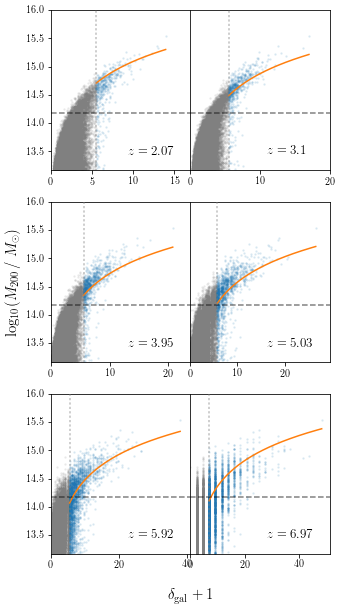

In [319]:
fig = plt.figure(figsize=(5,10))

gs1 = gridspec.GridSpec(3, 2)

gs1.update(wspace=0, hspace=0.2)

ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[0,1])
ax3 = fig.add_subplot(gs1[1,0])
ax4 = fig.add_subplot(gs1[1,1])
ax5 = fig.add_subplot(gs1[2,0])
ax6 = fig.add_subplot(gs1[2,1])

axes = [ax1,ax2,ax3,ax4,ax5,ax6]

def scale(x):
    return np.log10(x * 1e3 * 1e10)

for ax, z in zip(axes, zees):
    
    ax.text(0.55, 0.1, '$z = %s$'%z, transform=ax.transAxes, size=13)
    
    z_mask = (feature_array[:,1] == z) & fit_mask
    z_mask_all = (feature_array[:,1] == z) & (~fit_mask)
    
    # plot all points
    ax.plot(feature_array[z_mask_all,0]+1, scale(predictor_array[z_mask_all]), 
            '.', markersize=3, alpha=0.1, c='grey')
    
    # plot fitted points
    ax.plot(feature_array[z_mask,0]+1, scale(predictor_array[z_mask]), '.', markersize=3, alpha=0.1)
    
    
    dgal_range = np.linspace(feature_array[z_mask,0].min(), feature_array[z_mask,0].max(), np.sum(z_mask))
    
    ax.plot(dgal_range+1, scale(func(np.vstack([dgal_range, feature_array[z_mask,1]]),
                             popt[0], popt[1], popt[2], popt[3], popt[4])))
    
#     ax.plot(dgal_range+1, scale(linear_func(np.vstack([dgal_range, feature_array[z_mask,1]]),
#                              lin_popt[0], lin_popt[1], lin_popt[2], lin_popt[3], lin_popt[4])))
    
    ax.hlines(np.log10(1.48e14), 0, feature_array[z_mask,0].max() + 4, alpha=0.5, linestyle='dashed', color='black',zorder=10)
    
    ax.vlines(feature_array[z_mask,0].min() + 1, 13, 16, alpha=0.5, linestyle='dotted', color='grey',zorder=10)

    ax.set_xlim(0,feature_array[z_mask,0].max() + 4)
    ax.set_ylim(np.log10(1.48e13), 16)
    
    
for ax in [ax2, ax4, ax6]:
    ax.set_yticklabels([])
    ax.set_yticks([])
    
    
for ax in [ax3]:
    ax.set_ylabel('$\mathrm{log_{10}} (M_{200}\,/\;M_{\odot})$', size=15)
    
    
ax5.text(0.84, -0.3, '$\delta_{\mathrm{gal}} + 1$', transform = ax5.transAxes, size=15)

# plt.savefig(out_directory+'mass_fit.png', bbox_inches='tight', dpi=300)